# Motif Finding by Expectation-Maximization

EM algorithm으로 motif를 찾아본다.

생물정보학 및 실습 1, 2023년 1학기

In [1]:
seqs = """
CGCCCCTCTCGGGGGTGTTCAG
TGTGTAAGTGCCAAGGTGCCAG
ACCGAAAGAAGTATACAGGCGT
TTCAGGTGCACGTCGGTGAACC
CTCCACGTGCAATGTTGGCCTA""".split()
seqs

['CGCCCCTCTCGGGGGTGTTCAG',
 'TGTGTAAGTGCCAAGGTGCCAG',
 'ACCGAAAGAAGTATACAGGCGT',
 'TTCAGGTGCACGTCGGTGAACC',
 'CTCCACGTGCAATGTTGGCCTA']

In [2]:
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)

기본 파라미터 세팅

In [3]:
W = 8 # motif width
ALPHABET = 'ACGT'
N = len(ALPHABET)
L = len(seqs[0]) # length of each sequence
pseudocount = 1

ALPHABETenum = dict(zip(ALPHABET, range(N)))

다루기 쉽게 seqs를 숫자 배열로 변환함 (A->0, C->1, G->2, T->3)

In [4]:
X = np.array([[ALPHABETenum[c] for c in s] for s in seqs])
X

array([[1, 2, 1, 1, 1, 1, 3, 1, 3, 1, 2, 2, 2, 2, 2, 3, 2, 3, 3, 1, 0, 2],
       [3, 2, 3, 2, 3, 0, 0, 2, 3, 2, 1, 1, 0, 0, 2, 2, 3, 2, 1, 1, 0, 2],
       [0, 1, 1, 2, 0, 0, 0, 2, 0, 0, 2, 3, 0, 3, 0, 1, 0, 2, 2, 1, 2, 3],
       [3, 3, 1, 0, 2, 2, 3, 2, 1, 0, 1, 2, 3, 1, 2, 2, 3, 2, 0, 0, 1, 1],
       [1, 3, 1, 1, 0, 1, 2, 3, 2, 1, 0, 0, 3, 2, 3, 3, 2, 2, 1, 1, 3, 0]])

미리 전체 알파벳 빈도 계산하고 백그라운드 벡터 B 계산

In [5]:
nc = np.array([(X == i).sum() for i in range(N)])
B = (nc + pseudocount) / (nc + pseudocount).sum()
nc, B

(array([23, 29, 34, 24]),
 array([0.21052632, 0.26315789, 0.30701754, 0.21929825]))

시작 profile을 맨 앞 부분 길이가 W인 문자열로 초기화함

In [7]:
# motif 정의
M = np.zeros([N, W])

for j in range(W): # for each column of motif
    for c in range(N): # for each character in the alphabet
        M[c, j] = np.mean(X[:, j] == c)

M

array([[0.2, 0. , 0. , 0.2, 0.4, 0.4, 0.4, 0. ],
       [0.4, 0.2, 0.8, 0.4, 0.2, 0.4, 0. , 0.2],
       [0. , 0.4, 0. , 0.4, 0.2, 0.2, 0.2, 0.6],
       [0.4, 0.4, 0.2, 0. , 0.2, 0. , 0.4, 0.2]])

### E-step

Z matrix 계산

$Z_{ij}^{(t)} = \frac {\Pr(X_i | Z_{ij}=1,M^{(t)})} {\sum _{k=1} ^{L-W+1} { \Pr(X_i | Z_{ik}=1,M^{(t)})}}$

In [9]:
Z = np.zeros([X.shape[0], L-W+1]) # 폭의 L-W+1

# 먼저 분자의 Pr(Xi...)를 계산한다.
for i in range(X.shape[0]):
    for j in range(L-W+1):
        # motif 이전 background
        pr_beforemotif = B[X[i, :j]] #j 전까지 계산

        # motif 내부
        subseq = X[i, j:j+W] #motif 와 매치가 된다고 가정하는분부분
        pr_motif = np.choose(subseq, M)

        # motif 이후 background #motif 종료하고 sequence의 끝까지 부분
        pr_aftermotif = B[X[i, j+W:]]

        # 모두 곱해서 분모를 계산한다.
        probs = np.hstack([pr_beforemotif, pr_motif, pr_aftermotif])
        Z[i, j] = np.prod(probs)

        # 예시 좀 보여줌
        if i < 2 and j < 5:
            print(f'z[{i},{j}] =',
                ' * '.join(format(v, 'g') for v in probs),
                '=', format(Z[i, j], 'g'))

z[0,0] = 0.4 * 0.4 * 0.8 * 0.4 * 0.2 * 0.4 * 0.4 * 0.2 * 0.219298 * 0.263158 * 0.307018 * 0.307018 * 0.307018 * 0.307018 * 0.307018 * 0.219298 * 0.307018 * 0.219298 * 0.219298 * 0.263158 * 0.210526 * 0.307018 = 2.84101e-12
z[0,1] = 0.263158 * 0 * 0.2 * 0.8 * 0.4 * 0.2 * 0 * 0 * 0.2 * 0.263158 * 0.307018 * 0.307018 * 0.307018 * 0.307018 * 0.307018 * 0.219298 * 0.307018 * 0.219298 * 0.219298 * 0.263158 * 0.210526 * 0.307018 = 0
z[0,2] = 0.263158 * 0.307018 * 0.4 * 0.2 * 0.8 * 0.4 * 0.2 * 0.4 * 0.4 * 0.2 * 0.307018 * 0.307018 * 0.307018 * 0.307018 * 0.307018 * 0.219298 * 0.307018 * 0.219298 * 0.219298 * 0.263158 * 0.210526 * 0.307018 = 1.9887e-12
z[0,3] = 0.263158 * 0.307018 * 0.263158 * 0.4 * 0.2 * 0.8 * 0 * 0.2 * 0 * 0 * 0.6 * 0.307018 * 0.307018 * 0.307018 * 0.307018 * 0.219298 * 0.307018 * 0.219298 * 0.219298 * 0.263158 * 0.210526 * 0.307018 = 0
z[0,4] = 0.263158 * 0.307018 * 0.263158 * 0.263158 * 0.4 * 0.2 * 0.2 * 0.4 * 0.2 * 0.4 * 0.2 * 0.6 * 0.307018 * 0.307018 * 0.307018 * 0.21929

In [12]:
print('== 분모로 나누기 전 Z', '=' * 30)
print(Z)

# 각 sequence의 likelihood 총합을 계산해서 분모로 써서 나눈다.
Z = Z / Z.sum(axis=1)[:, np.newaxis]

print('== 분모로 나눈 후 Z', '=' * 30)
print(Z)

== 분모로 나누기 전 Z ==============================
[[2.84100575e-12 0.00000000e+00 1.98870402e-12 0.00000000e+00 5.47908252e-13 0.00000000e+00 2.01272419e-13 1.15012811e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.44272070e-12 0.00000000e+00 7.21360350e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00755750e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.31905892e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.23661774e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00755750e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.53319355e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.14501643e-12 3.68040995e-13 0.00000000

### M-step

`numpy`는 슬라이드 자료와 다르게 세로축을 먼저 쓰기 때문에 파라미터 순서도 k,c 대신 c,k로 바꿈.

$M^{(t+1)}(c,k) = \frac {n_{c,k} + d} {\sum _c {(n_{c,k} + d)}}$

$n_{c,k} = \sum _i \sum _{j|X_{i,j+k-1}=c} {Z_{ij}}$

In [11]:
n = np.zeros([N, W])

# 행렬 n 먼저 계산
for c in range(N):
    for k in range(W):
        # sum 순서는 sigma i 방향을 먼저 합하는 게 간단하므로 i먼저 j나중
        # X[:, <<7>>] == c는 boolean 벡터로, X_i,j+k-1=c 조건을 담당한다.
        n[c, k] = np.sum([(Z[:, j] * (X[:, j+k] == c)).sum()
                          for j in range(L-W+1)])

# M 계산
M = n + pseudocount
M = M / M.sum(axis=0)
M

array([[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]])

백그라운드 벡터 B 업데이트하기. 앞의 $n_{c,k}$와 마찬가지로 슬라이드와는 축을 반대로 써야 행렬을 표시했을 때 보기 편하다.

$B^{(t+1)}(c) = \frac {n_{c,0}+d} {\sum_c {(n_{c,0}+d)}}$

$n_{c,0}=n_c-\sum_{j=1}^W {n_{c,j}}$

In [24]:
# nc는 시작할 때 미리 계산해 두었다.
B = nc - n.sum(axis=1) + pseudocount
B = B / B.sum(axis=0)
B

array([0.21052632, 0.26315789, 0.30701754, 0.21929825])

### 함수로 모아 두기

여러 번 돌리기 쉽게 위의 코드를 모아서 함수로 만든다.

In [13]:
def Estep(X, B, L, W):
    Z = np.zeros([X.shape[0], L-W+1])

    for i in range(X.shape[0]):
        for j in range(L-W+1):
            pr_beforemotif = B[X[i, :j]]

            subseq = X[i, j:j+W]
            pr_motif = np.choose(subseq, M)

            pr_aftermotif = B[X[i, j+W:]]

            probs = np.hstack([pr_beforemotif, pr_motif, pr_aftermotif])
            Z[i, j] = np.prod(probs)

    return Z / Z.sum(axis=1)[:, np.newaxis]

In [14]:
# 서열 맨 앞부분을 모아서 만든 초기 M을 계산한다
def initialize_M(X, nc, N, W, pseudocount):
    M = np.zeros([N, W])

    for j in range(W): # for each column of motif
        for c in range(N): # for each character in the alphabet
            M[c, j] = np.mean(X[:, j] == c)

    B = (nc + pseudocount) / (nc + pseudocount).sum()

    return M, B

In [15]:
def Mstep(X, Z, nc, N, W, pseudocount):
    n = np.zeros([N, W])

    for c in range(N):
        for k in range(W):
            n[c, k] = np.sum([(Z[:, j] * (X[:, j+k] == c)).sum()
                             for j in range(L-W+1)])

    M = n + pseudocount
    M = M / M.sum(axis=0)

    B = nc - n.sum(axis=1) + pseudocount
    B = B / B.sum(axis=0)

    return M, B

모아서 돌려보기!

In [16]:
M, B = initialize_M(X, nc, N, W, pseudocount)
print('== (initial) M', '=' * 30)
print(M)
print('== (initial) B', '=' * 30)
print(B)

Z = Estep(X, B, L, W)
M, B = Mstep(X, Z, nc, N, W, pseudocount)
print('== (iteration 1) M', '=' * 30)
print(M)
print('== (iteration 1) B', '=' * 30)
print(B)

== (initial) M ==============================
[[0.2 0.  0.  0.2 0.4 0.4 0.4 0. ]
 [0.4 0.2 0.8 0.4 0.2 0.4 0.  0.2]
 [0.  0.4 0.  0.4 0.2 0.2 0.2 0.6]
 [0.4 0.4 0.2 0.  0.2 0.  0.4 0.2]]
== (initial) B ==============================
[0.21052632 0.26315789 0.30701754 0.21929825]
== (iteration 1) M ==============================
[[0.22222222 0.11111111 0.11111111 0.23796052 0.37727192 0.33907291 0.26692284 0.11111111]
 [0.32725859 0.28990272 0.57688777 0.36501435 0.22158926 0.26982019 0.11111111 0.2132287 ]
 [0.11111111 0.32994908 0.11111111 0.28591402 0.22216856 0.27999578 0.28453562 0.47590988]
 [0.33940808 0.26903709 0.20089001 0.11111111 0.17897027 0.11111111 0.33743043 0.19975031]]
== (iteration 1) B ==============================
[0.21633711 0.22468494 0.32559113 0.23338682]


3번 돌려 보기

In [17]:
M, B = initialize_M(X, nc, N, W, pseudocount)
Z = Estep(X, B, L, W)
M, B = Mstep(X, Z, nc, N, W, pseudocount)
Z = Estep(X, B, L, W)
M, B = Mstep(X, Z, nc, N, W, pseudocount)
Z = Estep(X, B, L, W)
M, B = Mstep(X, Z, nc, N, W, pseudocount)

print('== (iteration 3) M', '=' * 30)
print(M)
print('== (iteration 3) B', '=' * 30)
print(B)

== (iteration 3) M ==============================
[[0.18634348 0.16151798 0.15604622 0.32259716 0.33310843 0.27520033 0.1916729  0.14200058]
 [0.29672636 0.29843151 0.49845559 0.32271989 0.27562042 0.241829   0.13888125 0.23649783]
 [0.14897844 0.32498821 0.14900403 0.21700835 0.2086034  0.3396363  0.32400109 0.43846767]
 [0.36795172 0.2150623  0.19649417 0.1376746  0.18266775 0.14333438 0.34544476 0.18303392]]
== (iteration 3) B ==============================
[0.21734617 0.2326695  0.31951098 0.23047335]


delta M이 0.01% 이하가 될 때까지 E-M 반복하기

> 종료조건: 변화 폭이 적어지면 종료

In [21]:
deltaM_threshold = 1e-4
datalog = {'deltaM': [], 'B': [], 'Z': [], 'M': []}

M, B = initialize_M(X, nc, N, W, pseudocount)
for i in range(10000): # 최대 iteration 수를 10000으로 제한한다.
    prev_M = M
    Z = Estep(X, B, L, W)
    M, B = Mstep(X, Z, nc, N, W, pseudocount)

    # M 변화를 계산하고 주요 값들을 저장한다.
    delta = (np.abs(M - prev_M) / M).mean()
    datalog['deltaM'].append(delta)
    datalog['B'].append(B)
    datalog['Z'].append(Z)
    datalog['M'].append(M)
    if delta < deltaM_threshold:
        break

print(f'== (iteration {i+1}) M', '=' * 30)
print(M)
print(f'== (iteration {i+1}) B', '=' * 30)
print(B)

== (iteration 19) M ==============================
[[0.1143238  0.22200403 0.12633712 0.54199454 0.21546759 0.13138975 0.11396067 0.11433231]
 [0.15282959 0.31616389 0.43851547 0.20013071 0.24550357 0.11365736 0.20826352 0.12252571]
 [0.11693418 0.23270185 0.12532932 0.1347949  0.42318754 0.63773664 0.23597487 0.64113687]
 [0.61591243 0.22913022 0.30981809 0.12307985 0.1158413  0.11721625 0.44180094 0.1220051 ]]
== (iteration 19) B ==============================
[0.2402934  0.29488772 0.27121398 0.1936049 ]


$\Delta M$ 과 B 변화를 찍어본다.

In [19]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'Iteration')

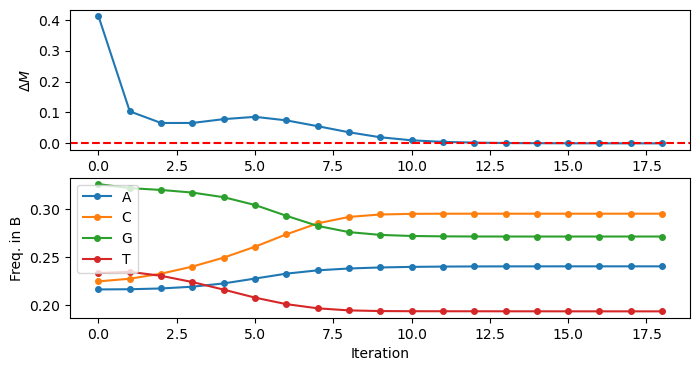

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4))
axes[0].plot(datalog['deltaM'], marker='o', markersize=4)
axes[0].axhline(deltaM_threshold, color='r', linestyle='--')
axes[0].set_ylabel('$\Delta M$')

axes[1].plot(datalog['B'], marker='o', markersize=4, label=['A', 'C', 'G', 'T'])
axes[1].legend()
axes[1].set_ylabel('Freq. in B')
axes[1].set_xlabel('Iteration')

Z, M의 변화도 한 번 찍어본다. Z에서는 맨 앞이 선택되다가 점차 뒤로 이동해서 motif가 제대로 선택되는 것이 보인다.

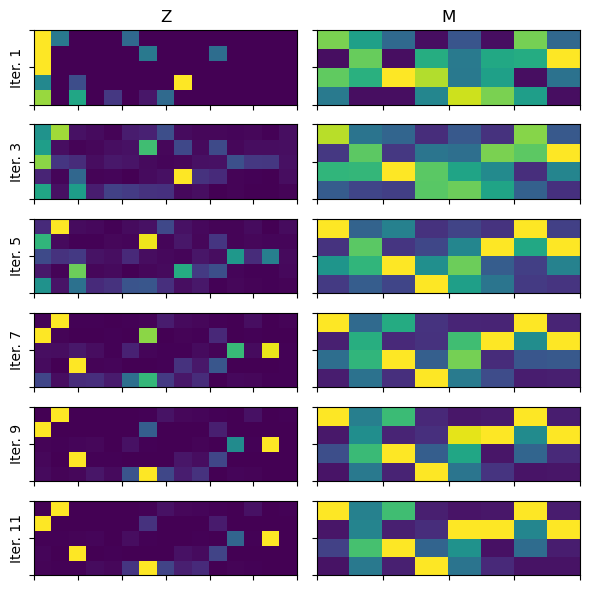

In [25]:
fig, axes = plt.subplots(6, 2, figsize=(6, 6))

# 왼쪽에는 Z를 그림
for ax, i in zip(axes[:, 0], range(0, len(datalog['Z']), 2)):
    ax.pcolor(datalog['Z'][i], vmin=0, vmax=.5)
    plt.setp(ax.get_yticklabels() + ax.get_xticklabels(), visible=False)
    ax.set_ylabel(f'Iter. {i+1}')
    if i == 0:
        ax.set_title('Z')

# 오른쪽에 M 그림
for ax, i in zip(axes[:, 1], range(0, len(datalog['M']), 2)):
    ax.pcolor(datalog['M'][i], vmin=0.1, vmax=.4)
    plt.setp(ax.get_yticklabels() + ax.get_xticklabels(), visible=False)
    if i == 0:
        ax.set_title('M')

plt.tight_layout()

Consensus 모티프 찍어보기

In [34]:
# M 에서 최대 확률인 염기들을 모은 consensus
consensus = ''.join(np.choose(M.argmax(axis=0), 'ACGT'))

# Z 에서 가장 확률이 높은 부분들을 고른 instances
instances = [seqs[i][j:j+W] for i, j in enumerate(Z.argmax(axis=1))]

print(consensus, '\t(consensus)')
print('--' * 10)
print(*instances, sep='\n')

TCCAGGTG 	(consensus)
--------------------
TCTCGGGG
TGTAAGTG
TACAGGCG
TTCAGGTG
TCCACGTG
